<a href="https://colab.research.google.com/github/JuanArmas/BigDataSNS/blob/main/Actividad_3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Casen 2017.
La Encuesta Casen en Chile es un estudio integral que examina la situación de los hogares y la población, enfocándose en aspectos clave como salud, educación, vivienda, trabajo, etnia e ingresos.
Ampliar el alcance y la profundidad de esta encuesta por medio de la correlación de estas variables entre sí, posibilitaría una comprensión aún más precisa de los desafíos socioeconómicos actuales. Esto podría permitir el diseño de programas y políticas más efectivas, dirigidos a mejorar de manera específica las condiciones de vida de los grupos más vulnerables en la sociedad chilena.

El objetivo que me planteo con este problema de Clasificación será el tratar de predecir la relación de pobreza en base a la etnia en relación con los ingresos, edad y el nivel de escolaridad.


Más información:

https://observatorio.ministeriodesarrollosocial.gob.cl/preguntas-frecuentes#:~:text=Sus%20objetivos%20son%20los%20siguientes,vivienda%2C%20trabajo%2C%20e%20ingresos.


In [ ]:
# carga de datos
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


##CARGA Y NORMALIZACIÓN DE DATOS:


#### Cargamos datos desde repo local e indicamos con codificación ISO-8859-1, que cree el dataframe y que separe por ","

In [ ]:
def upload_files ():
  #Lee el archivo desde local
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    #Crea el dataFrame separado por ","
    #df_Casen = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), sep=',')
    df_Casen = pd.read_csv(io.StringIO(uploaded[fn].decode('ISO-8859-1')), sep=';')
    return df_Casen

In [ ]:
df_Casen = upload_files()
df_Casen

Saving 01_casen_2017_muestra.csv to 01_casen_2017_muestra (6).csv
User uploaded file "01_casen_2017_muestra (6).csv" with length 14152 bytes


,sexo,sexo_cod,edad,etnia,es_indigena,pobreza_ingreso,esc,ingreso,qaut,qautr
0,Mujer,1,56,Aimara,Indigena,No pobres,12.0,250000.0,3.0,3.0
1,Mujer,1,21,No pertenece a ningún pueblo indígena,No indigena,No pobres,7.0,211091.0,3.0,3.0
2,Hombre,0,24,No pertenece a ningún pueblo indígena,No indigena,No pobres,12.0,281750.0,4.0,4.0
3,Hombre,0,28,No pertenece a ningún pueblo indígena,No indigena,No pobres,12.0,311750.0,4.0,4.0
4,Hombre,0,26,No pertenece a ningún pueblo indígena,No indigena,No pobres,15.0,341667.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
194,Hombre,0,16,No pertenece a ningún pueblo indígena,No indigena,No pobres,10.0,NaN,4.0,4.0
195,Mujer,1,10,No pertenece a ningún pueblo indígena,No indigena,No pobres,NaN,NaN,4.0,4.0
196,Hombre,0,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,Mujer,1,37,No pertenece a ningún pueblo indígena,No indigena,No pobres,15.0,NaN,4.0,4.0


In [ ]:
# El QAUT se enfoca en la distribución del ingreso per cápita del hogar a nivel nacional.
# El QAUTR considera esta distribución según la zona residencial de los hogares, dividiendo el país en áreas urbanas y rurales.
# Tanto el QAUT como el QAUTR tienen cinco niveles del 1(20% más pobre) al 5(20% más rico) (Quintiles)

# mirar características que puede dar la librería Kbest para elegir las mejores

### Transformación de variables categóricas a numéricas
##### incido sobre todo en la columna "etnia", ya que es la que más diversidad tiene

In [ ]:
print(df_Casen.columns)

In [ ]:
#Busco valores diferentes en "etnia"
df_Casen['etnia'].unique()

In [ ]:
df_Casen['etnia'].replace(['Aimara','No pertenece a ningún pueblo indígena','Mapuche','Diaguita',' ','Quechua','Collas',
                                  'Yámana o Yagán','Atacameño (Likan-Antai)','Kawashkar o Alacalufes','Rapa-Nui o Pascuenses'],
                                   [2,3,4,5,3,6,7,8,9,10,11], inplace=True)
df_Casen['pobreza_ingreso'].replace(['No pobres','Pobres extremos','Pobres no extremos'],[12, 13,14], inplace=True)
df_Casen['es_indigena'].replace(['Indigena','No indigena'],[15,16], inplace=True)

# Rellenamos los espacios vacios cambiando los NaN por valores medios
# Columnas a rellenar
columns_to_impute = ['etnia', 'es_indigena','pobreza_ingreso', 'esc', 'ingreso', 'qaut', 'qautr']

# Rellenar los NaN con la media de cada columna
for column in columns_to_impute:
    df_Casen[column].fillna(df_Casen[column].mean(), inplace=True)

# Escalamos con MinMaxScaler la columna ingresos para acotar sus rangos de valores entre 0-1 para que sea más manejable

column_to_scale = 'ingreso'
scaler = MinMaxScaler()
# Ajustar y transformar la columna 'ingreso'
df_Casen[[column_to_scale]] = scaler.fit_transform(df_Casen[[column_to_scale]])

# Se muestra el conjunto de datos con los valores normalizados
df_Casen

,sexo,sexo_cod,edad,etnia,es_indigena,pobreza_ingreso,esc,ingreso,qaut,qautr
0,Mujer,1,56,2.000000,15.000000,12.000000,12.000000,0.055197,3.000000,3.000000
1,Mujer,1,21,3.000000,16.000000,12.000000,7.000000,0.046417,3.000000,3.000000
2,Hombre,0,24,3.000000,16.000000,12.000000,12.000000,0.062362,4.000000,4.000000
3,Hombre,0,28,3.000000,16.000000,12.000000,12.000000,0.069131,4.000000,4.000000
4,Hombre,0,26,3.000000,16.000000,12.000000,15.000000,0.075883,2.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...
194,Hombre,0,16,3.000000,16.000000,12.000000,10.000000,0.145496,4.000000,4.000000
195,Mujer,1,10,3.000000,16.000000,12.000000,12.240741,0.145496,4.000000,4.000000
196,Hombre,0,43,4.564103,15.861538,12.076531,12.240741,0.145496,3.326531,3.346939
197,Mujer,1,37,3.000000,16.000000,12.000000,15.000000,0.145496,4.000000,4.000000


In [ ]:
df_Casen.describe()

##Usando herramientas: Matriz de correlación

<ipython-input-86-011457a3fb8e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_Casen.corr(), square=True, annot=True)


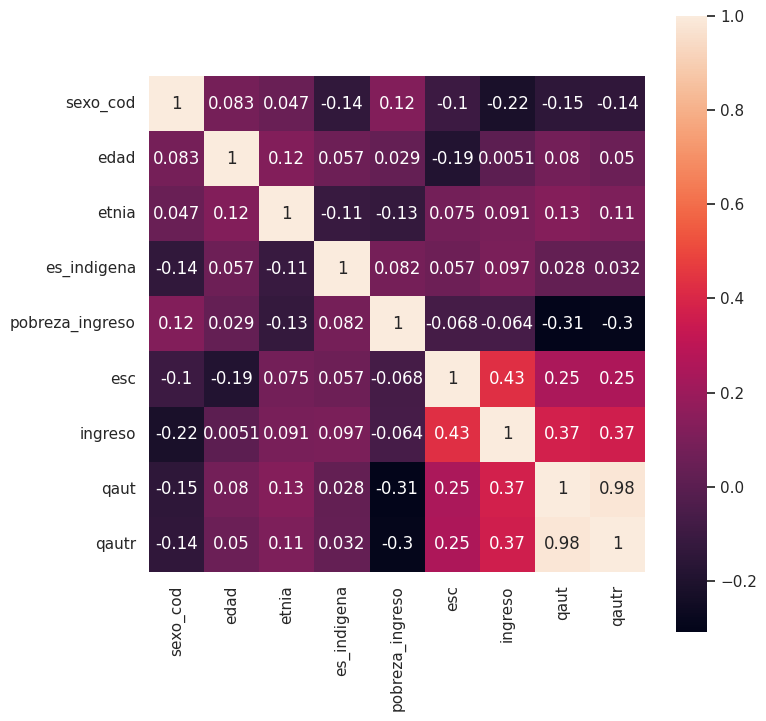

In [86]:
sns.set()
plt.figure(figsize=(8,8))  # Tamaño personalizado de la figura
sns.heatmap(df_Casen.corr(), square=True, annot=True)
plt.show()

##Usando herramientas: Matriz de dispersión

<Figure size 800x800 with 0 Axes>

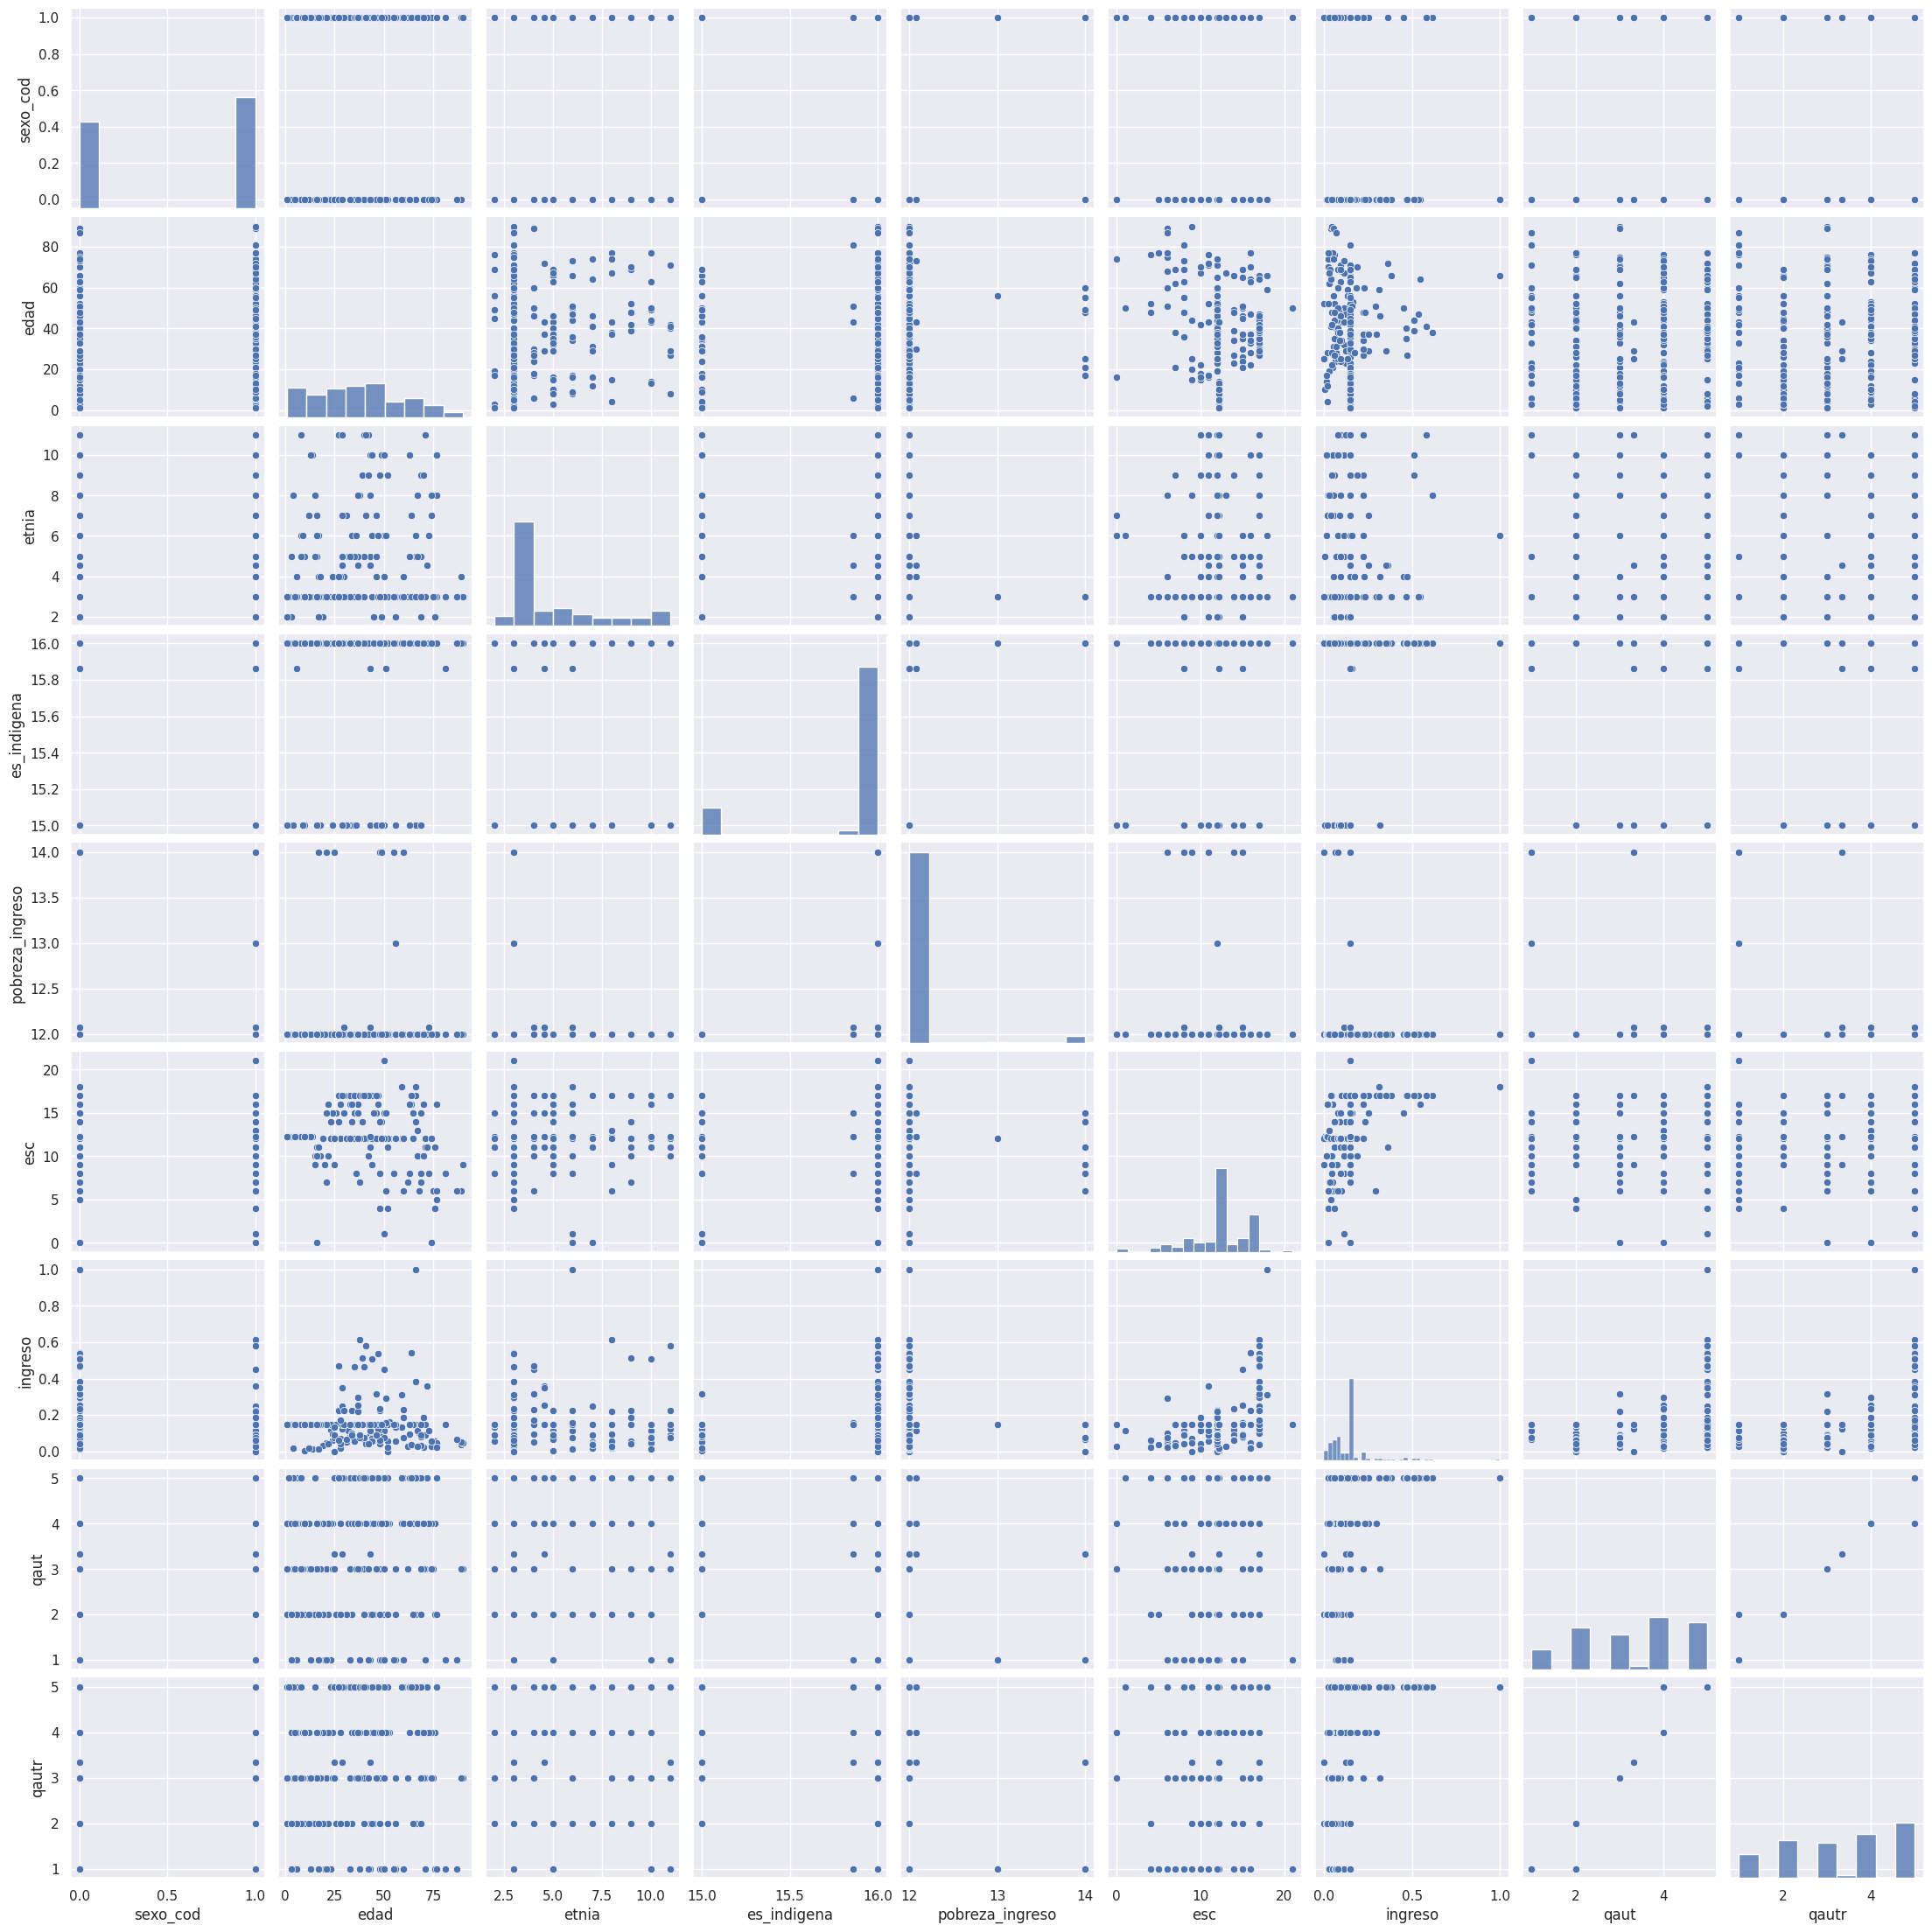

In [ ]:
sns.pairplot(df_Casen, vars=['sexo_cod', 'edad', 'etnia', 'es_indigena', 'pobreza_ingreso', 'esc', 'ingreso', 'qaut', 'qautr'], height=2)
sns.pairplot(df_Casen, vars=['sexo_cod', 'edad', 'etnia', 'es_indigena', 'pobreza_ingreso', 'esc', 'ingreso', 'qaut', 'qautr'], height=2)


<Figure size 700x700 with 0 Axes>

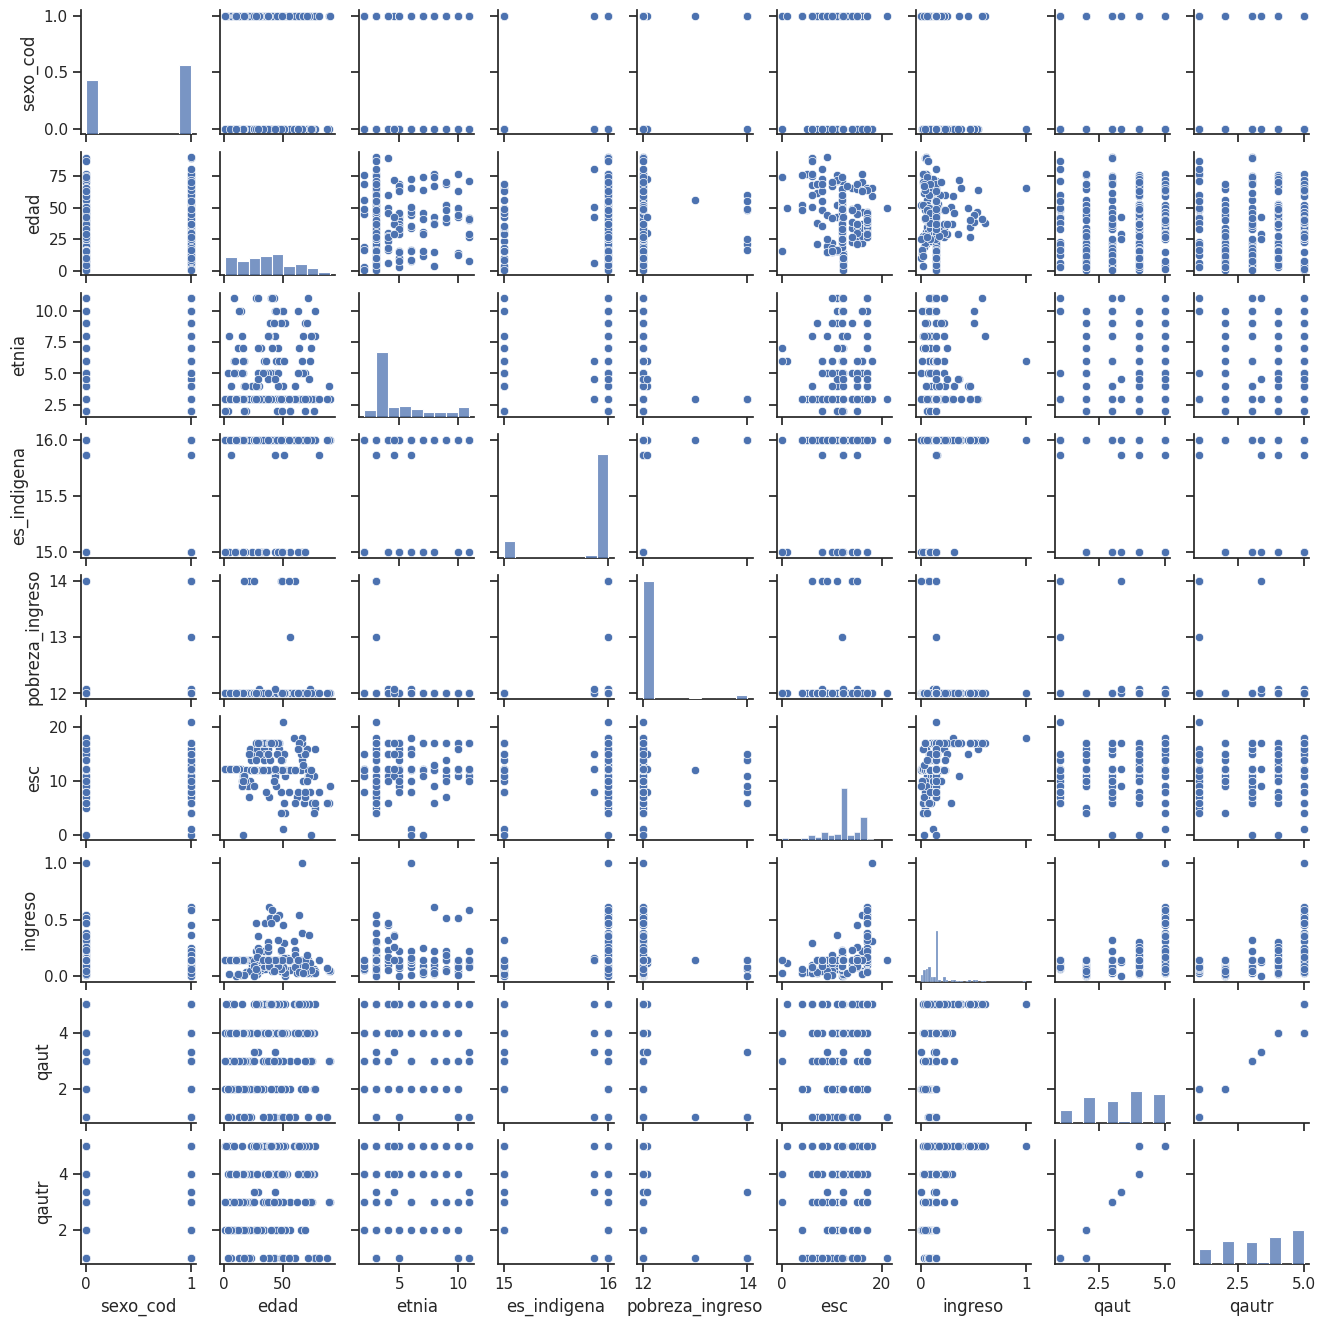

In [94]:
# Definir el conjunto de variables que deseas visualizar
variables = ['sexo_cod', 'edad', 'etnia', 'es_indigena', 'pobreza_ingreso', 'esc', 'ingreso', 'qaut', 'qautr']
# Configurar el tamaño y el tamaño de la imagen
plt.figure(figsize=(7,7))
sns.pairplot(df_Casen, vars=variables, height=1.5)
# Mostrar el gráfico
plt.show()

##Usando herramientas: SelectKbest


In [ ]:
name_features_casen = ['sexo_cod', 'edad', 'es_indigena', 'pobreza_ingreso', 'esc', 'ingreso', 'qaut', 'qautr']
X_casen = df_Casen[name_features_casen]
y_casen = df_Casen['etnia']

X_train_casen, X_test_casen, y_train_casen, y_test_casen = train_test_split(X_casen, y_casen, test_size=.2, random_state=42)


X_train_casen_ar = X_train_casen.to_numpy()
y_train_casen_ar = y_train_casen.to_numpy()
X_test_casen_ar = X_test_casen.to_numpy()
# Usar SelectKBest con f_classif para seleccionar las k características que están más correlacionadas
selector = SelectKBest(f_classif, k=3) # En K le indicamos el número de características que queremos seleccionar

# Muestra las características seleccionadas
X_train_casen_char_selected = selector.fit(X_train_casen_ar, y_train_casen_ar)

char_selected = X_train_casen_char_selected.get_feature_names_out(name_features_casen)

# Con este método selecciona las mejores características y filas que no están correlacionadas
X_train_casen_selected = selector.fit_transform(X_train_casen_ar, y_train_casen_ar)
X_test_casen_selected = selector.transform(X_test_casen_ar)

char_selected


array(['edad', 'es_indigena', 'ingreso'], dtype=object)

## Usando NaiveBayes modelo (...)

###Sin Cross Validation

###Con Cross Validation

Webgrafia:

- https://colab.research.google.com/drive/1_760l-ArDZPws8WNo5XpVYXNQT6T2FH3?hl=es#scrollTo=QD0T9mVLt_qt
- https://colab.research.google.com/drive/1f7pje4J7UxUD6qlRS2wjdWmsVdpaVmVy?hl=es#scrollTo=WXPWzdmax-lx
- https://colab.research.google.com/drive/1nXthaKc-r5L43RoqyhfSPlmmTYLolkAS?usp=sharing#scrollTo=rZ8tJ_75pnf2
- https://www.linkedin.com/pulse/an%C3%A1lisis-exploratorio-de-datos-con-python-almudena-bonaplata/?originalSubdomain=es
- https://joserzapata.github.io/courses/python-ciencia-datos/visualizacion/seaborn/
- https://rpubs.com/dataintelligence/variables_de_la_casen
- https://observatorio.ministeriodesarrollosocial.gob.cl/storage/docs/casen/2017/Programacion_de_Medicion_de_Pobreza_Multidimensional_2017.pdf_Casen
-